In [1]:
from helperFunctions import *

In [2]:

df = pd.read_csv('./ml_task_data.csv')
df['CompletionDate'] = pd.to_datetime(df.CompletionDate)
df['CompletionDate'] = df['CompletionDate'].dt.strftime('%Y')

df['SpudDate'] = pd.to_datetime(df.SpudDate)
df['SpudDate'] = df['SpudDate'].dt.strftime('%Y')

df.dropna(how='all', subset=['SpudDate', 'CompletionDate'], inplace=True)

In [3]:

basin_compdate_grouped = df.groupby(["Basin", "CompletionDate"])
basin_grouped = df.groupby(["Basin"])
state_grouped = df.groupby(["State"])
spud_date_grouped = df.groupby(['SpudDate'])


In [4]:

for key, item in spud_date_grouped:
    df.loc[(df['SpudDate'] == key), 'CompletionDate'] = item['CompletionDate'].fillna(item['CompletionDate'].mode()[0])


In [5]:

for key, item in state_grouped:
    state = key
    basin_mode = item["Basin"].mode()[0]
    df.loc[(df["State"] == state), "Basin"] = item["Basin"].fillna(basin_mode)
    

In [6]:
for key, item in basin_grouped:
    basin = key
    state_mode = item["State"].mode()[0]
    df.loc[(df["Basin"] == basin), "State"] = item["State"].fillna(state_mode)
    df.loc[(df["Basin"] == basin), "Latitude"] = item["Latitude"].fillna(item["Latitude"].median())
    df.loc[(df["Basin"] == basin), "Longitude"] = item["Longitude"].fillna(item["Longitude"].median())



In [7]:

for key, item in basin_compdate_grouped:
    basin = key[0]
    compdate = key[1]

    bvhh_median = item["BVHH"].median()
    lat_length_in_miles_median = item['LateralLengthInMiles'].median()

    if math.isnan(bvhh_median):
        bvhh_median = df.loc[(df["Basin"] == basin)]["BVHH"].median()
    
    if math.isnan(bvhh_median):
        bvhh_median = df.loc[(df["CompletionDate"] == compdate)]["BVHH"].median()
    
    if math.isnan(bvhh_median):
        bvhh_median = df["BVHH"].median()

    if math.isnan(bvhh_median):
        bvhh_median = 1


    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df.loc[(df["Basin"] == basin)]["LateralLengthInMiles"].median()
    
    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df.loc[(df["CompletionDate"] == compdate)]["LateralLengthInMiles"].median()
    
    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = df["LateralLengthInMiles"].median()

    if math.isnan(lat_length_in_miles_median):
        lat_length_in_miles_median = 0.75

    
    # Updating bvhh nan values
    df.loc[(df["Basin"] == basin) & (df["CompletionDate"] == compdate), "BVHH"] = item['BVHH'].fillna(bvhh_median)

    # Updating LateralLengthInMiles nan values
    df.loc[(df["Basin"] == basin) & (df["CompletionDate"] == compdate), "LateralLengthInMiles"] = item['LateralLengthInMiles'].fillna(lat_length_in_miles_median)
    


In [8]:
state_grouped = df.groupby(["State"])

for key, item in state_grouped:
    state = key
    
    formation_alias_mode_arr = item['formationAlias'].mode()
    
    if len(formation_alias_mode_arr) == 0: # check if mode is nan
        formation_alias_mode_arr = df["formationAlias"].mode()

    df.loc[(df['State'] == state), 'formationAlias'] = item['formationAlias'].fillna(formation_alias_mode_arr[0])


In [9]:

df['OperatorAlias'] = df['OperatorAlias'].fillna(df['OperatorAlias'].mode()[0])


In [10]:
df.dropna(inplace=True)

In [11]:
df['CompletionDate'] = df['CompletionDate'].astype(int)
df['SpudDate'] = df['SpudDate'].astype(int)

In [12]:
print(df.isnull().sum(axis = 0))
print(df['proppantPerFoot'].count())

Basin                   0
State                   0
Latitude                0
Longitude               0
PadName                 0
SpudDate                0
CompletionDate          0
OperatorAlias           0
formationAlias          0
LateralLengthInMiles    0
BVHH                    0
proppantPerFoot         0
dtype: int64
50554


In [13]:
X_train, X_test, Y_train, Y_test = generate_train_test(df, xcolumns=['Latitude', 'formationAlias', 'BVHH', 'CompletionDate', 'State', 'Basin', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.one_hot_encoding, normalized=False, test_size=0.2)

In [14]:

model = RandomForestRegressor(n_estimators=50, max_features=3)
model.fit(X_train, Y_train)


RandomForestRegressor(max_features=3, n_estimators=50)

In [15]:
y_pred = model.predict(X_test)

In [16]:
# print(y_pred.mean(), Y_test.mean())
ytest_list = Y_test.to_list()
for i in range(1,21):
    print(ytest_list[i], y_pred[i])
# print(y_pred[:20])
# print(Y_test.to_list()[:20])

2604.3743315508 2611.8641337977883
1667.2936259143 1837.6331475025281
297.8371659416 663.9389112748103
1841.1466314399 1801.2331635366866
633.9400967137 807.3622440719237
665.444340796 592.5117594514279
1658.8094373866 1606.0792129438805
1961.8936423054001 1956.8239282406848
1307.0154291225 1315.6372899274588
309.2137058262 469.0747203767658
453.2895354294 592.9982599049151
1801.6436147645002 944.1457616930741
1247.4675019577 929.2116960244323
395.2543841336 393.60545590017216
551.3851151237001 415.5901346925641
541.3928035982 560.7735456944102
209.6698893544 407.63425429727397
1570.0371157210998 1654.4260074394126
905.3554042904 903.8938081423998
1417.4144963916 1364.6591777609356


In [17]:
r2_score(y_true=ytest_list, y_pred=y_pred)

0.7504116457426723

In [18]:

mean_squared_error(ytest_list,y_pred, squared=False)


397.2313707843986

In [18]:

print(np.median(ytest_list), np.median(y_pred))


1090.4947208122 1095.063694971233


Mean squared errors avg = 360.0697834267758
R2 Score avg = 0.7968906076227595


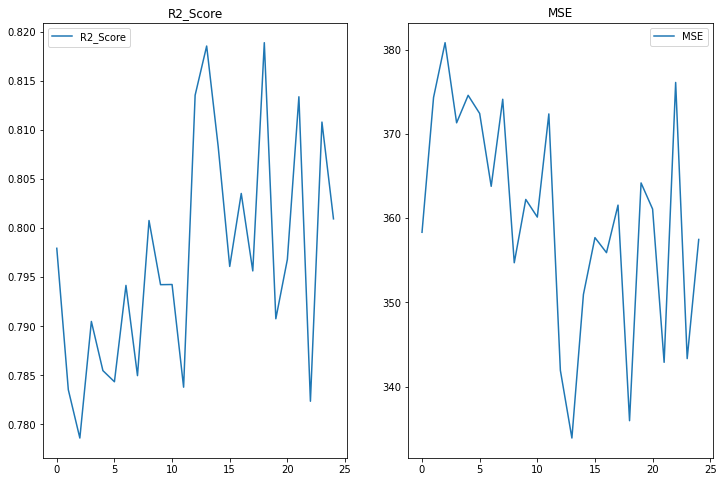

In [19]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=25)

Mean squared errors avg = 348.6945124607427
R2 Score avg = 0.8088956154205909


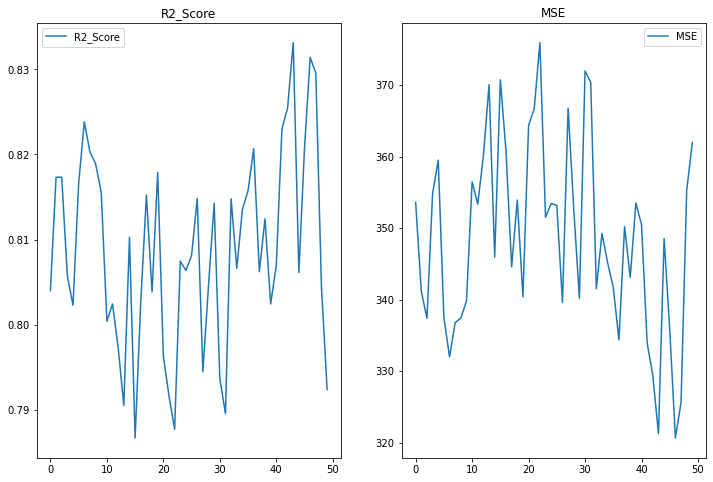

In [20]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'formationAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 336.04232862017943
R2 Score avg = 0.8220390457111477


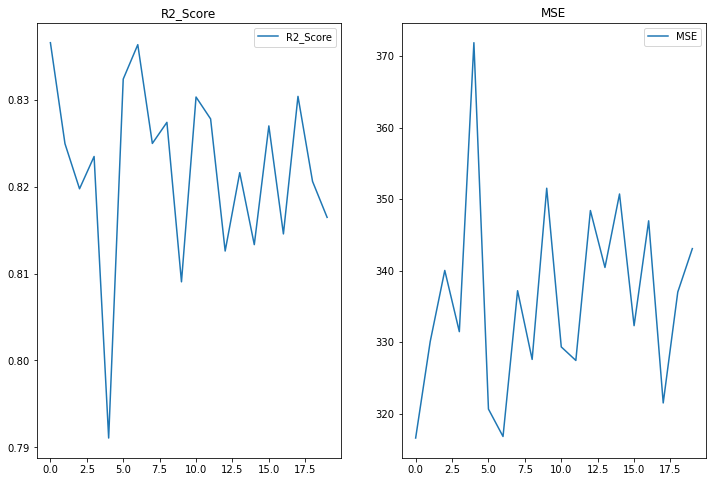

In [20]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=20)


Mean squared errors avg = 337.83254084990483
R2 Score avg = 0.8204528593290332


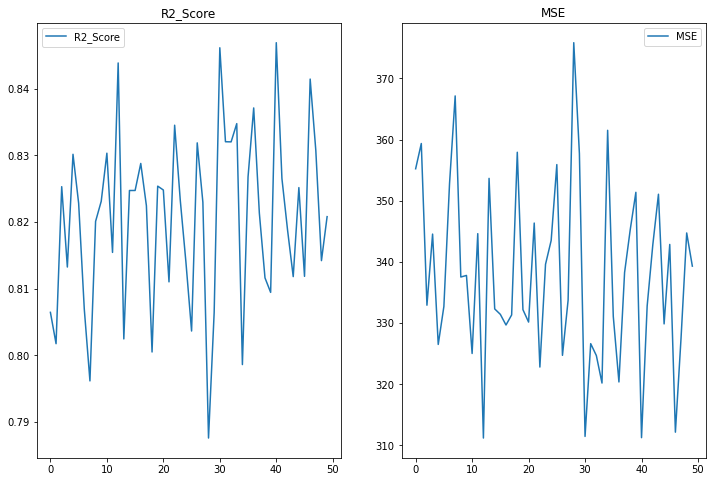

In [22]:
plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)

Mean squared errors avg = 333.72244627461805
R2 Score avg = 0.8246873865516772


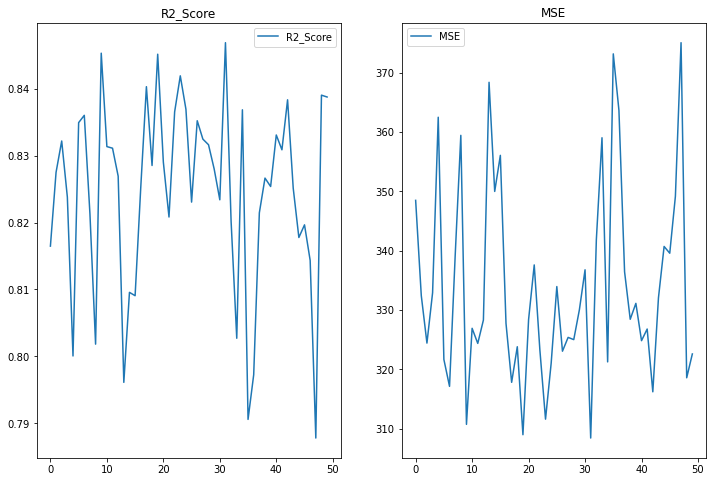

In [23]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'OperatorAlias', 'formationAlias', 'Basin', 'BVHH', 'CompletionDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 345.27950072979615
R2 Score avg = 0.8119942465188007


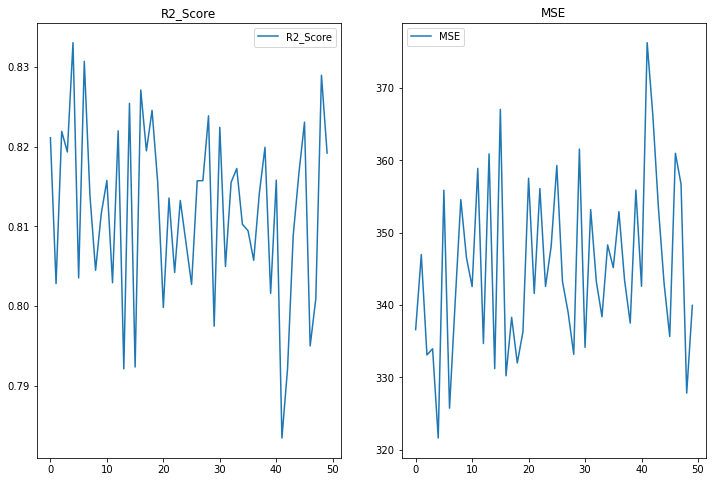

In [24]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'formationAlias', 'BVHH', 'CompletionDate', 'SpudDate', 'State', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=False, test_size=0.2, runtimes=50)


Mean squared errors avg = 330.64341198540336
R2 Score avg = 0.82702804089945


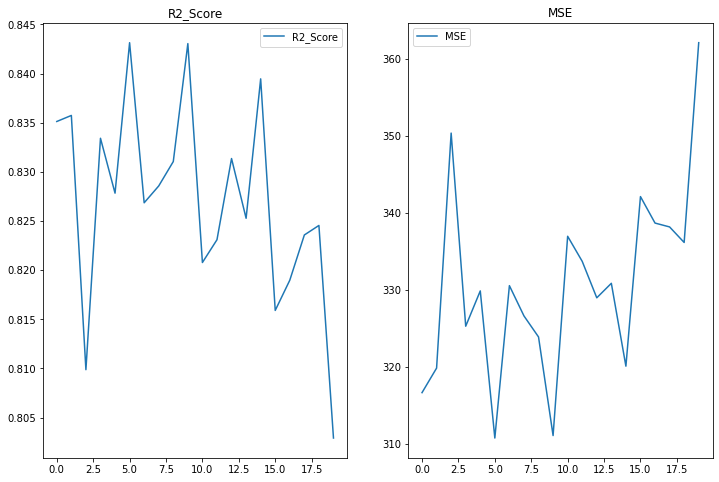

In [23]:

plot_metrics(df, xcolumns=['Latitude', 'Longitude', 'BVHH', 'OperatorAlias', 'formationAlias', 'CompletionDate', 'SpudDate', 'LateralLengthInMiles'], ycolumn='proppantPerFoot', encoding_type=encodingTypes.categorization, normalized=True, test_size=0.2, runtimes=20)
